In [1]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

In [6]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
def energy_stats(network):
    blind_sample_z, blind_sample_x, blind_energy_z, blind_energies_x, _ = network.sample(temperature=1.0, nsample=100000)
    nlow = np.size(np.where(blind_energies_x < 100)[0])
    return blind_energies_x.min(), nlow

def sample_stats(d):
    from deep_boltzmann.util import count_transitions, acf
    ntrans = count_transitions(d, 1.25, 1.75)
    acf100 = acf(d, 100)
    acf1000 = acf(d, 1000)
    acf10000 = acf(d, 10000)
    return ntrans, acf100[0], acf1000[0], acf10000[0]

def distance_metric(x):
    """ Outputs 2.5 for closed and 5 for open dimer
    """
    d = model.dimer_distance_tf(x)
    dscaled = 3.0 * (d - 1.5)
    return 2.5 * (1.0 + tf.sigmoid(dscaled))

In [8]:
# reweighting
def test_sample_rew(network, rcfunc, rcmin, rcmax, temperature=1.0, nsample=100000):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=nsample)
    bin_means, Es = free_energy_bootstrap(rcfunc(sample_x), rcmin, rcmax, 100, sample=100, weights=np.exp(log_w))
    fig = plt.figure(figsize=(5, 4))
    # model.plot_dimer_energy()
    plt.ylim(-10, 20)
    Emean = mean_finite(Es, axis=0)-7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, 2*Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return fig, bin_means, Emean, Estd

In [9]:
def plot_convergence(losses, acceptance_rate, stepsize=None, figsize=(5, 8)):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figsize)
    niter = len(losses)
    xticks = np.arange(niter) + 1
    # ML loss
    losses_ML = np.array(losses)[:, 1]
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    # KL loss
    losses_KL = np.array(losses)[:, 2]
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    if stepsize is None:
        # acceptance rate
        axes[2].plot(xticks, acceptance_rate, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Acc. rate')
        axes[2].set_xlabel('Training iterations')
    else:
        # MCMC efficiency (adaptive)
        efficiency = np.array(acceptance_rate) * np.array(stepsize)
        axes[2].plot(xticks, efficiency, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Efficiency')
        axes[2].set_xlabel('Training iterations')
    return fig, axes

In [10]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---

In [11]:
# load trajectory data
trajdict = np.load('../data/particles_tilted/trajdata_long.npz')
import ast
params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [12]:
# create model
params['grid_k'] = 0.0
model = ParticleDimer(params=params)

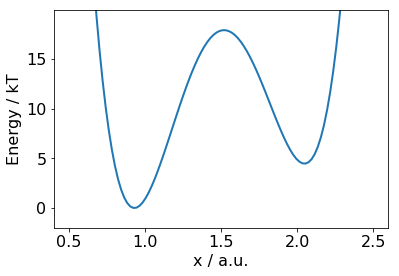

In [13]:
xx, xE = model.plot_dimer_energy()

In [14]:
W = np.exp(-xE)
-np.log(np.sum(W[xx < 1.5]) / np.sum(W[xx >= 1.5]))

-4.4139043664615345

In [15]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

Umbrella samplinig reference
-------

In [16]:
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling
from deep_boltzmann.sampling.metropolis import MetropolisGauss

In [16]:
## Either run Umbrella Sampling here....
#sampler = MetropolisGauss(model, model.init_positions(1.0), noise=0.02, stride=10)
#sampler.run(nsteps=10000)
#us = UmbrellaSampling(model, sampler, model.dimer_distance, sampler.traj[-1], 30, 250, 0.7, 2.3, forward_backward=True)
#us.run(nsteps=20000, verbose=True)

0.15 -60.78149494219376
0.15 -54.80906030006441
0.15 -66.82129157380976
0.25 -34.02408228190505
0.25 -36.378770183999876
0.25 -31.033689809728696
0.5 -14.286441470542922
0.5 -15.261248313620838
0.5 -13.63487889725406
1.0 -6.628717637498096
1.0 -7.124522164227016
1.0 -7.547679576558392
2.0 -3.3690130502955613
2.0 -3.298268077804168
2.0 -3.0709626368335443


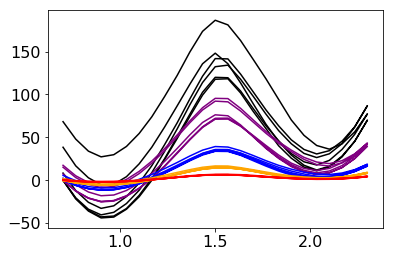

In [16]:
## ... or load saved Umbrella Sampling data.
npzfile = np.load(paper_dir + 'figs/particles/US_data.npz')
colors = ['black', 'purple', 'blue', 'orange', 'red']
x = npzfile['umbrella_positions']
temperatures_US = npzfile['temperatures']
dF_closed_open_US = []
for i, dF in enumerate(npzfile['umbrella_free_energies']):
    icolor = i // 3
    plt.plot(x, dF, color=colors[icolor])
    W = np.exp(-dF)
    dF_at_kT0 = -np.log(np.sum(W[x < 1.5]) / np.sum(W[x >= 1.5]))
    dF_closed_open_US.append(dF_at_kT0)
    print(temperatures_US[i], dF_at_kT0)    

In [17]:
# Estimate free energy profile and errors at kT=1 
umbrella_positions = npzfile['umbrella_positions']
# split in two halves because we ran forward and backward
umbrella_positions = umbrella_positions[:umbrella_positions.size//2]
umbrella_free_energies = [npzfile['umbrella_free_energies'][i][:umbrella_positions.size] for i in range(9, 12)] \
                       + [npzfile['umbrella_free_energies'][i][umbrella_positions.size:][::-1] for i in range(9, 12)] 
# align values
umbrella_free_energies = [F-F.mean() for F in umbrella_free_energies]

Boltzmann Generator
-------

In [19]:
batchsize_ML = 128
batchsize_KL = 1000
noise_intensity = 0.05

In [20]:
X0 = np.repeat(traj_closed_train[-1:], 1000, axis=0)
#X0 = np.vstack([traj_open_train[:1], traj_closed_train[:1]])

In [21]:
X0noise = X0 + noise_intensity * np.random.randn(X0.shape[0], X0.shape[1])
X0noise = X0noise.astype(np.float32)

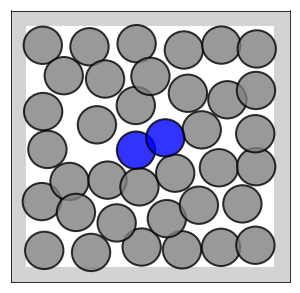

In [22]:
model.draw_config(X0noise[1], dimercolor='blue', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particles/explore_initconf.pdf', bbox_inches='tight')

In [23]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh') # , whiten=X0noise

<RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0
Instructions for updating:
Colocations handled automatically by placer.


In [24]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0noise, xval=xval, epochs=200, lr=0.00025, batch_size=batchsize_ML, 
                                             std=1.0, verbose=0, return_test_energies=False)

Instructions for updating:
Use tf.cast instead.


(-150, 200)

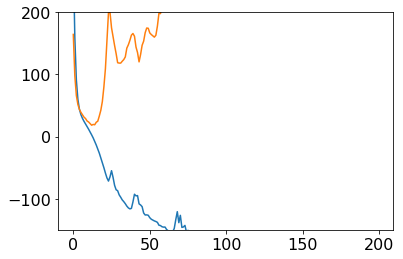

In [25]:
plt.plot(loss_bg_trainML)
plt.plot(loss_bg_valML)
plt.ylim(-150, 200)

(0, 3)

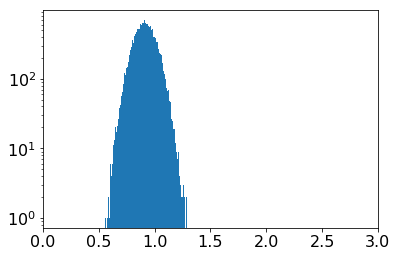

In [26]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

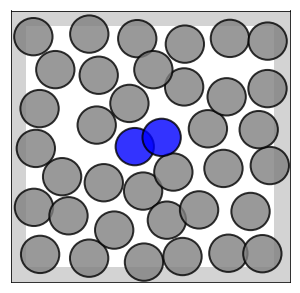

In [27]:
model.draw_config(sample_x[100], dimercolor='blue', alpha=0.8);

Adaptive sampling
-----

In [28]:
temperature=1.0

In [29]:
from deep_boltzmann.networks.training import ParticleFilter
from deep_boltzmann.sampling.permutation import HungarianMapper

In [30]:
mapper = HungarianMapper(model.init_positions(1.5), identical_particles=np.arange(2, model.nparticles))

In [82]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh') # , whiten=X0noise

<RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0
Before connect
 layer 0
 layer 1
 layer 2
 layer 3
 layer 4
 layer 5
 layer 6
 layer 7
 layer 8
 layer 9
Done xz
 layer 9
 layer 8
 layer 7
 layer 6
 layer 5
 layer 4
 layer 3
 layer 2
 layer 1
 layer 0
Done zx


In [83]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0noise, xval=xval, epochs=200, lr=0.00025, batch_size=batchsize_ML, 
                                             std=1.0, verbose=0, return_test_energies=False)

In [84]:
particle_filter_ex = ParticleFilter(bg, X0noise, 100000, lr=0.0001, batch_size=batchsize_KL, 
                                    high_energy=10000, max_energy=1e10, std=1.0, 
                                    w_ML=1.0, w_KL=1.0, w_RC=1.0, 
                                    rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5,
                                    weigh_ML=False, mapper=mapper)

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'index_layer_21/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'index_layer_24/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'index_layer_24/GatherV2:0' shape=(?, 76) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [85]:
Ds = [model.dimer_distance(X0noise)]

In [90]:
niter = 20
for i in range(niter):
    print('\nITER',(i+1),'/',niter)
    particle_filter_ex.train(epochs=50, stepsize=None, verbose=1)
    Ds.append(model.dimer_distance(particle_filter_ex.X))


ITER 1 / 5
Epoch 0/50 loss 132.3857 index_layer_21_loss -172.6438 index_layer_24_loss 276.3021 index_layer_24_loss 28.7274 p_acc 0.179 step 0.6061995788831566
Epoch 1/50 loss 132.3017 index_layer_21_loss -172.6919 index_layer_24_loss 276.0443 index_layer_24_loss 28.9492 p_acc 0.165 step 0.6061995788831566
Epoch 2/50 loss 132.6253 index_layer_21_loss -172.3611 index_layer_24_loss 275.6455 index_layer_24_loss 29.3408 p_acc 0.161 step 0.6061995788831566
Epoch 3/50 loss 133.2073 index_layer_21_loss -172.6396 index_layer_24_loss 276.5747 index_layer_24_loss 29.2722 p_acc 0.184 step 0.6061995788831566
Epoch 4/50 loss 132.7486 index_layer_21_loss -172.5075 index_layer_24_loss 276.0672 index_layer_24_loss 29.1888 p_acc 0.17 step 0.6061995788831566
Epoch 5/50 loss 132.6470 index_layer_21_loss -172.6476 index_layer_24_loss 276.5197 index_layer_24_loss 28.7748 p_acc 0.219 step 0.6061995788831566
Epoch 6/50 loss 133.0227 index_layer_21_loss -172.5004 index_layer_24_loss 276.7953 index_layer_24_lo

Epoch 5/50 loss 132.5567 index_layer_21_loss -172.2090 index_layer_24_loss 276.2101 index_layer_24_loss 28.5556 p_acc 0.161 step 0.6061995788831566
Epoch 6/50 loss 132.9446 index_layer_21_loss -171.4711 index_layer_24_loss 275.8146 index_layer_24_loss 28.6011 p_acc 0.165 step 0.6061995788831566
Epoch 7/50 loss 132.0305 index_layer_21_loss -171.5756 index_layer_24_loss 274.5540 index_layer_24_loss 29.0522 p_acc 0.175 step 0.6061995788831566
Epoch 8/50 loss 131.7100 index_layer_21_loss -171.7899 index_layer_24_loss 274.7436 index_layer_24_loss 28.7563 p_acc 0.169 step 0.6061995788831566
Epoch 9/50 loss 131.8360 index_layer_21_loss -171.9533 index_layer_24_loss 275.0632 index_layer_24_loss 28.7261 p_acc 0.182 step 0.6061995788831566
Epoch 10/50 loss 132.0509 index_layer_21_loss -171.7473 index_layer_24_loss 275.0065 index_layer_24_loss 28.7917 p_acc 0.149 step 0.6061995788831566
Epoch 11/50 loss 132.2009 index_layer_21_loss -171.4355 index_layer_24_loss 274.4333 index_layer_24_loss 29.203

Epoch 11/50 loss 132.6697 index_layer_21_loss -171.0718 index_layer_24_loss 274.9250 index_layer_24_loss 28.8164 p_acc 0.154 step 0.6061995788831566
Epoch 12/50 loss 138.4249 index_layer_21_loss -170.9693 index_layer_24_loss 280.2195 index_layer_24_loss 29.1746 p_acc 0.156 step 0.6061995788831566
Epoch 13/50 loss 135.4785 index_layer_21_loss -169.6853 index_layer_24_loss 276.1723 index_layer_24_loss 28.9915 p_acc 0.15 step 0.6061995788831566
Epoch 14/50 loss 140.0962 index_layer_21_loss -166.4229 index_layer_24_loss 277.6556 index_layer_24_loss 28.8635 p_acc 0.137 step 0.6061995788831566
Epoch 15/50 loss 140.2182 index_layer_21_loss -166.2339 index_layer_24_loss 278.0314 index_layer_24_loss 28.4207 p_acc 0.14 step 0.6061995788831566
Epoch 16/50 loss 140.8614 index_layer_21_loss -165.2624 index_layer_24_loss 277.3974 index_layer_24_loss 28.7264 p_acc 0.124 step 0.6061995788831566
Epoch 17/50 loss 141.2184 index_layer_21_loss -165.4830 index_layer_24_loss 277.4709 index_layer_24_loss 29.

Epoch 16/50 loss 134.5071 index_layer_21_loss -168.9086 index_layer_24_loss 274.5580 index_layer_24_loss 28.8577 p_acc 0.128 step 0.6061995788831566
Epoch 17/50 loss 135.2478 index_layer_21_loss -169.2453 index_layer_24_loss 275.2950 index_layer_24_loss 29.1982 p_acc 0.13 step 0.6061995788831566
Epoch 18/50 loss 133.1068 index_layer_21_loss -169.2793 index_layer_24_loss 273.4629 index_layer_24_loss 28.9231 p_acc 0.158 step 0.6061995788831566
Epoch 19/50 loss 134.7571 index_layer_21_loss -168.9514 index_layer_24_loss 274.3694 index_layer_24_loss 29.3391 p_acc 0.133 step 0.6061995788831566
Epoch 20/50 loss 133.8403 index_layer_21_loss -169.7979 index_layer_24_loss 274.5699 index_layer_24_loss 29.0683 p_acc 0.129 step 0.6061995788831566
Epoch 21/50 loss 133.6463 index_layer_21_loss -169.3349 index_layer_24_loss 274.0263 index_layer_24_loss 28.9548 p_acc 0.125 step 0.6061995788831566
Epoch 22/50 loss 133.8776 index_layer_21_loss -168.9315 index_layer_24_loss 273.9456 index_layer_24_loss 28

Epoch 22/50 loss 132.1066 index_layer_21_loss -169.4687 index_layer_24_loss 272.7611 index_layer_24_loss 28.8142 p_acc 0.145 step 0.6061995788831566
Epoch 23/50 loss 132.7471 index_layer_21_loss -169.6042 index_layer_24_loss 273.3121 index_layer_24_loss 29.0393 p_acc 0.148 step 0.6061995788831566
Epoch 24/50 loss 131.5252 index_layer_21_loss -169.9996 index_layer_24_loss 272.4469 index_layer_24_loss 29.0779 p_acc 0.14 step 0.6061995788831566
Epoch 25/50 loss 131.9578 index_layer_21_loss -169.8518 index_layer_24_loss 272.7795 index_layer_24_loss 29.0300 p_acc 0.147 step 0.6061995788831566
Epoch 26/50 loss 131.6016 index_layer_21_loss -170.5721 index_layer_24_loss 273.1999 index_layer_24_loss 28.9738 p_acc 0.149 step 0.6061995788831566
Epoch 27/50 loss 132.0629 index_layer_21_loss -169.8530 index_layer_24_loss 273.0111 index_layer_24_loss 28.9048 p_acc 0.147 step 0.6061995788831566
Epoch 28/50 loss 132.6219 index_layer_21_loss -169.9854 index_layer_24_loss 273.3995 index_layer_24_loss 29

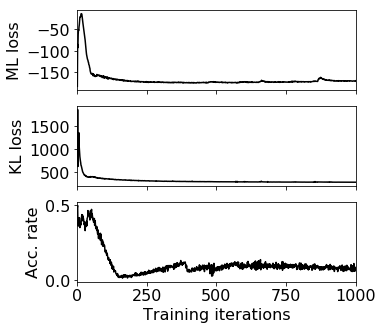

In [96]:
plot_convergence(particle_filter_ex.loss_train, particle_filter.acceptance_rate, figsize=(5, 5));
plt.savefig(paper_dir + 'figs/particles/explore_conv2.pdf', bbox_inches='tight')

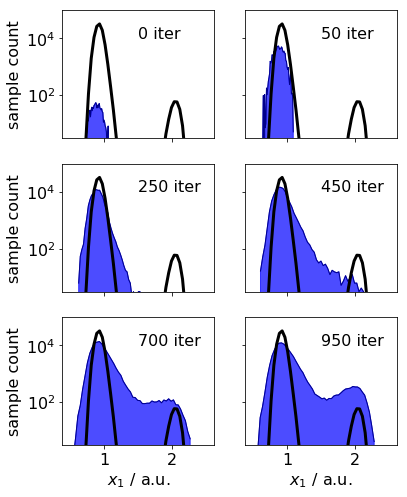

In [97]:
#plot_indices = np.array([0, 1, 2, 5, 10, 19])
plot_indices = np.array([0, 1, 5, 9, 14, 19])
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6,8))

for i, ax in zip(plot_indices, axes.flatten()):
    h, e = np.histogram(Ds2[i], bins=50)
    e = 0.5*(e[:-1] + e[1:])
    ax.plot(e, h, color='darkblue', linewidth=1)
    ax.fill_between(e, np.zeros(len(e)), h, color='blue', alpha=0.7)
    ax.text(1.5, 10000, str(i*50)+' iter')
    ax.plot(umbrella_positions, 100000*np.exp(-np.mean(umbrella_free_energies, axis=0)), 
            color='black', linewidth=3, label='Eq. dist.')    
    ax.semilogy()
    #plt.legend(ncol=1, fontsize=16, frameon=False)
    ax.set_ylim(3, 100000)
axes[-1, 0].set_xlabel('$x_1$ / a.u.')
axes[-1, 1].set_xlabel('$x_1$ / a.u.')
axes[0, 0].set_ylabel('sample count')
axes[1, 0].set_ylabel('sample count')
axes[2, 0].set_ylabel('sample count')
plt.savefig(paper_dir + 'figs/particles/explore_conv_hist2.pdf', bbox_inches='tight')